Purpose: In the context of text-image retrieval tasks, an app could provide a user-friendly interface for interacting with the retrieval system. Users can input queries, and results will be displayed efficiently.

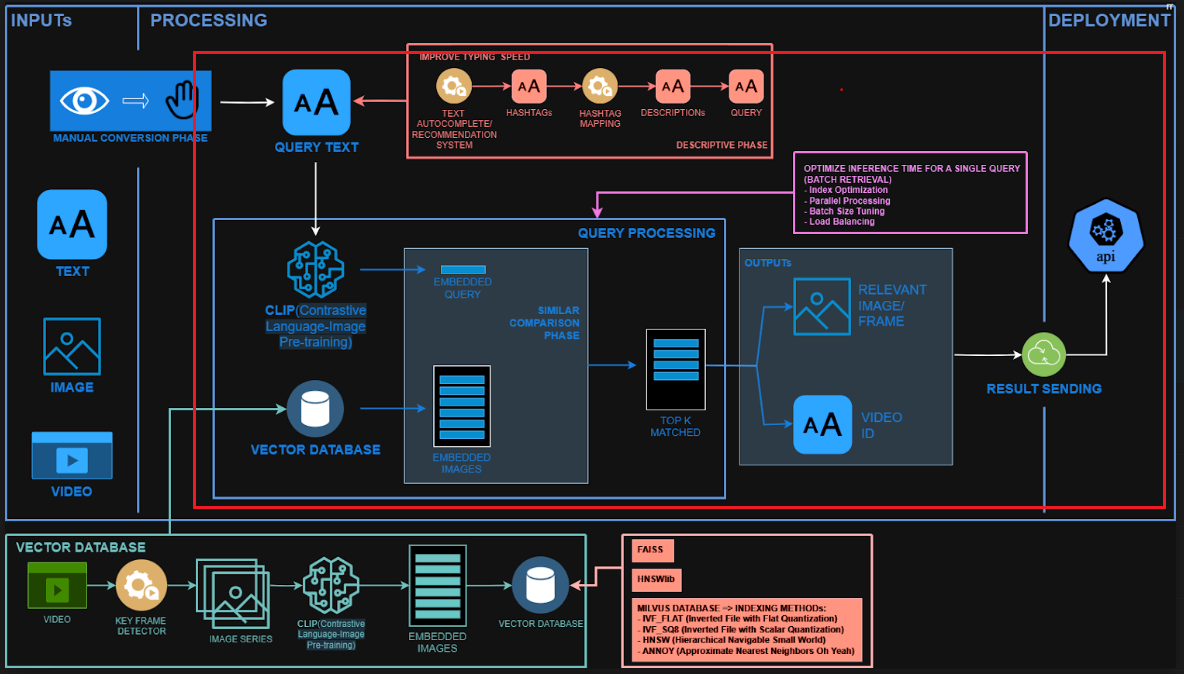

#Install dependency

In [ ]:
#uncomment and run this line if running on Colab:
!pip -q install fastapi nest_asyncio pyngrok uvicorn multiprocess

#!pip -q install faiss-gpu  # or faiss-cpu if you don't have GPU support
!pip -q install faiss-cpu
!pip -q install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 986.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 651.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from fastapi import FastAPI, Request, Form, File, UploadFile
from fastapi.templating import Jinja2Templates
from fastapi.staticfiles import StaticFiles
from pydantic import BaseModel
from typing import List, Optional

import multiprocessing
import faiss

import json
import cv2
import numpy as np

import base64
import random

import torch
import clip

import logging
import sys

import gdown

import time

##Load sample

In [ ]:
"""
/content/
│
├── key_frame_folder/
│   ├── key_frame_New_VTV24/
│   │   ├── New_VTV24_960_1020_0.jpeg
│   │   ├── New_VTV24_600_660_2.jpeg
│   │   └── ...
│   └── key_frame_New_truyenhinhnhandantv/
│       ├── New_truyenhinhnhandantv_180_240_1.jpeg
│       ├── New_truyenhinhnhandantv_840_900_2.jpeg
│       ├── New_truyenhinhnhandantv_480_540_0.jpeg
│       └── ...
│
├── templates/
│   ├── home.html
│   ├── layout.html
│   └── show_results.html
│
├── index_image_video_dict.json
├── key_frame_folder.zip
├── merged_index_hnsw.bin
└── video_path_dict.json

"""

In [ ]:
#Load database (merged_index_hnsw.bin)
!gdown 1-2dpWfxx0Sgh1fPYhT6wdG_SNTXQO8z_
#Load annotation (original_video_paths) (video_path_dict.json)
!gdown 1-5d1QP_8tgv5A1A9TTzENjUpqfWaTF01
#Load annotation (index_image_video_dict) (index_image_video_dict.json)
!gdown 1-1FifKSgD_Yf10ucdBbS-l5QOctYiQ5d

In [ ]:
#Load key frame folder (key_frame_folder.zip)
!gdown 1-1tNaT2IAaAcTbfdpNxiPVi7WJ87WubW
#Unzip key frame folder (key_frame_folder)
!unzip -q /content/key_frame_folder.zip

In [ ]:
#Load templates
gdown.download_folder('https://drive.google.com/drive/folders/1tee_kpfWgCKzoyQHznMtkPMVQFOkldHf?usp=sharing', quiet=True)

['/content/templates/home.html',
 '/content/templates/layout.html',
 '/content/templates/show_results.html']

#App

In [ ]:
# Configure logging to output to the notebook
logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

#Creates a FastAPI instance
app = FastAPI()

# Mount the content directory to serve static files
app.mount("/content/key_frame_folder", StaticFiles(directory="/content/key_frame_folder"), name="key_frame_folder")
# Pass templates location to all views in FastAPI
templates = Jinja2Templates(directory = 'templates')
database_selection_options = ['FAISS']

##############################################
#-------------GET Request Routes--------------
##############################################
@app.get("/")
def home(request: Request):
    return templates.TemplateResponse('home.html',
     {
         "request": request,
         "database_selection_options": database_selection_options,
         })

##############################################
#------------POST Request Routes--------------
##############################################
@app.post("/")
def retrieval_with_server_side_rendering(request: Request,
                                         query_text: str = Form(...),
                                         database_name: str = Form('FAISS'),
                                         k: int = Form(640)):
    start_time = time.time()
    #Specify the paths to the database, image folder, annotation (reading from json file)
    database_path = 'merged_index_hnsw.bin'
    key_frame_folder_path =  'key_frame_folder'
    video_path_dict_path =  'video_path_dict.json'
    with open(video_path_dict_path, 'r') as openfile:
      original_video_dict = json.load(openfile)
    index_image_video_dict_path =  'index_image_video_dict.json'
    with open(index_image_video_dict_path, 'r') as openfile:
      index_image_video_dict = json.load(openfile)
    logger.info("Setup is ready!!!")

    #Prepare index
    if database_name == 'FAISS':
      num_threads = multiprocessing.cpu_count() # Set the number of threads for search operations
      logger.info(f"Number of threads: {num_threads}")
      faiss.omp_set_num_threads(num_threads) # Set the number of threads to use
      # memory-map the index file, allowing efficient access without loading the entire index into RAM
      index_hnsw = faiss.read_index(database_path, faiss.IO_FLAG_MMAP)
      # Optionally configure the index parameters, to control the search behavior
      #index_hnsw.nprobe = 32 # Number of clusters to search, for example
      logger.info("The HNSW index is ready!!!")

    #Load the CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    logger.info(f"Device: {device}")
    model, preprocess = clip.load("ViT-B/32", device=device)
    logger.info("The CLIP model is ready!!!")

    #Retrieval process
    query_vector = encode_description(model, device, query_text)
    distances_hnsw, indices_hnsw = k_image_search(query_vector, index_hnsw, device, k=k)
    logger.info("The retrieval process is completed!!!")
    results = extract_information(distances_hnsw, indices_hnsw, index_image_video_dict, original_video_dict)
    execution_time = time.time() - start_time
    logger.info("The result-extracting process is completed!!!")
    logger.info(f"Program Executed in {execution_time}")

    return templates.TemplateResponse('show_results.html', {
            'request': request,
            'query_text': query_text,
            'k': k,
            'results': results,
        })

##############################################
#--------------Helper Functions---------------
##############################################

#Query Encoding with CLIP
def encode_description(model, device, description):
  text_inputs = clip.tokenize([description]).to(device) # Tokenize and encode the description
  with torch.no_grad():
      text_features = model.encode_text(text_inputs)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  query_vector = text_features #text_features.cpu().numpy()
  return query_vector

#Retrieval using CLIP and FAISS
def k_image_search(query_vector, index_hnsw, device, k = 5):
  if device == "cuda":
    vector_data = query_vector.cpu().numpy().astype(np.float32) #send to cpu to query
  vector_data = query_vector
  distances_hnsw, indices_hnsw = index_hnsw.search(vector_data, k) #query
  return distances_hnsw[0], indices_hnsw[0]

#Information-extracting from the retrieval results
def extract_information(distances, indices, index_image_video_dict, original_video_dict):
  info_list = []
  for i, (score, idx) in enumerate(zip(distances, indices)):
    videoID = index_image_video_dict[str(idx)][1]
    #img_path = index_image_video_dict[str(idx)][0]
    img_path = index_image_video_dict[str(idx)][0].replace('/content/key_frame_folder','')
    info_list.append({videoID: {'score': score,
                                'idx': idx,
                                'image_path': img_path,
                                'video_path': original_video_dict[videoID]}})
  return info_list

In [ ]:
#Run the APP on Colab Notebook
from pyngrok import ngrok
!ngrok authtoken '2jIENOfBWZ4ienOg02pxrmOrHlX_6ckA3v5EGABJMQXrB9SHH' # Add your ngrok authentication
import nest_asyncio
import uvicorn

# Create tunnel
public_url = ngrok.connect(8000)
# Allow for asyncio to work within the Jupyter notebook cell
nest_asyncio.apply()
# Run the FastAPI app using uvicorn
print(f'PLEAS CLICK THIS URL {public_url} TO ACCESS THE APP!!!')
uvicorn.run(app)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
PLEAS CLICK THIS URL NgrokTunnel: "https://af75-34-74-165-252.ngrok-free.app" -> "http://localhost:8000" TO ACCESS THE APP!!!


INFO:     Started server process [170]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     115.76.50.179:0 - "GET / HTTP/1.1" 200 OK
INFO:     115.76.50.179:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found


INFO:__main__:Setup is ready!!!
INFO:__main__:Number of threads: 2
INFO:__main__:The HNSW index is ready!!!
INFO:__main__:Device: cpu
INFO:__main__:The CLIP model is ready!!!
INFO:__main__:The retrieval process is completed!!!
INFO:__main__:The result-extracting process is completed!!!
INFO:__main__:Program Executed in 6.781739711761475


INFO:     115.76.50.179:0 - "POST / HTTP/1.1" 200 OK
INFO:     115.76.50.179:0 - "GET /content/key_frame_folder/key_frame_New_truyenhinhnhandantv/New_truyenhinhnhandantv_900_960_2.jpeg HTTP/1.1" 200 OK
INFO:     115.76.50.179:0 - "GET /content/key_frame_folder/key_frame_New_truyenhinhnhandantv/New_truyenhinhnhandantv_900_960_0.jpeg HTTP/1.1" 200 OK
INFO:     115.76.50.179:0 - "GET /content/key_frame_folder/key_frame_New_VTV24/New_VTV24_720_780_2.jpeg HTTP/1.1" 200 OK
INFO:     115.76.50.179:0 - "GET /content/key_frame_folder/key_frame_New_VTV24/New_VTV24_1080_1140_2.jpeg HTTP/1.1" 200 OK
INFO:     115.76.50.179:0 - "GET /content/key_frame_folder/key_frame_New_truyenhinhnhandantv/New_truyenhinhnhandantv_840_900_0.jpeg HTTP/1.1" 200 OK
INFO:     115.76.50.179:0 - "GET /content/key_frame_folder/key_frame_New_truyenhinhnhandantv/New_truyenhinhnhandantv_540_600_0.jpeg HTTP/1.1" 200 OK
INFO:     115.76.50.179:0 - "GET /content/key_frame_folder/key_frame_New_VTV24/New_VTV24_0_60_1.jpeg HTTP/1

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [170]


In [ ]:
# Kill tunnel
ngrok.disconnect(public_url=public_url)

##Document:
- https://github.com/WelkinU/yolov5-fastapi-demo/blob/main/server.py
- https://github.com/tiangolo/full-stack-fastapi-template?fbclid=IwZXh0bgNhZW0CMTAAAR2wah_c3jxBTmiF6DUWua4XP39Gh3gATmBdbG9YAEpYWc98cstRGq7XQgA_aem_LTuvbW7rni4jfvhfZWnWOQ